In [1]:
import tensorflow as tf
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [2]:
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [669]:
train_data = joblib.load('unet_train_data.joblib')
labels = joblib.load("unet_train_labels.joblib")

In [670]:
IMG_SIZE = (32,32)

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, train_data, labels, batch_size, is_train=True):
        
        self.train_data = train_data
        self.labels = labels
        self.batch_size = batch_size
        self.is_train = is_train
    
    def __getitem__(self, index):
        train_data_batch = self.train_data[index * self.batch_size:(index + 1) * self.batch_size]
        labels_batch = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        cliped_data_batch = []
        cliped_label_batch = []
        for i in range(len(train_data_batch)):
            if self.is_train:
                random_statr_x = np.random.randint(6, IMG_SIZE[0]-6)
                random_statr_y = np.random.randint(6, IMG_SIZE[1]-6)
            else:
                random_statr_x = 16
                random_statr_y = 16
            # random_statr_x = np.random.randint(10, 22)
            # random_statr_y = np.random.randint(10, 22)
            
            
                
            
            cliped_data = train_data_batch[i][:, random_statr_x:random_statr_x+IMG_SIZE[0], 
                                                 random_statr_y:random_statr_y+IMG_SIZE[1]].copy()

            cliped_data = np.moveaxis(cliped_data, 0, -1)
    
            
            cliped_label = labels_batch[i][random_statr_x:random_statr_x+IMG_SIZE[0], 
                                           random_statr_y:random_statr_y+IMG_SIZE[1]].copy()
            
            if self.is_train and np.random.uniform() > 0.6:
                cliped_data = np.flip(cliped_data, 0)
                cliped_label = np.flip(cliped_label, 0)
                
            if self.is_train and np.random.uniform() > 0.6:
                cliped_data = np.flip(cliped_data, 1)
                cliped_label = np.flip(cliped_label, 1)
                
             
            if self.is_train and np.random.uniform() > 0.6:
                # x = np.where(cliped_data[:, :, 7]> 0)[0][0]
                # y = np.where(cliped_data[:, :, 7]> 0)[1][0]
                # print(x, y)
                # if x > 11 and y > 11:
                for i in range(4):
                    random_cutout_x = np.random.randint(3, 30)
                    random_cutout_y = np.random.randint(3, 30)
                    cliped_data[random_cutout_x-3:random_cutout_x, random_cutout_y-3:random_cutout_y, :7] = 0
                
            if self.is_train and np.random.uniform() > 0.6:
                cliped_data = cliped_data + np.random.normal(0, 0.003, cliped_data.shape)    
            
            cliped_data_batch.append(cliped_data)
            cliped_label_batch.append(cliped_label)
        
        cliped_data_batch = np.array(cliped_data_batch)
        cliped_label_batch = np.array(cliped_label_batch).astype(float)
        
        # for i in range(cliped_data_batch.shape[-1] - 1):
        #     cliped_data_batch[:,:,:,i] = (cliped_data_batch[:,:,:,i] - cliped_data_batch[:,:,:,i].mean()) / cliped_data_batch[:,:,:,i].std()
        
        return cliped_data_batch, cliped_label_batch
        
    def __len__(self):
        return len(self.labels) // self.batch_size

In [671]:
train_data = np.where(train_data<=-3000, 0, train_data)

In [672]:
wind_speed = np.sqrt(train_data[:, 3, :, :]**2 + train_data[:, 4, :, :]**2)
angle = np.mod(180 + (180 / np.pi) * np.arctan2(train_data[:, 3, :, :], train_data[:, 4, :, :]), 360)
train_data[:, 3, :, :] = wind_speed
train_data[:, 4, :, :] = angle

In [674]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data, labels, test_size=0.15, random_state=42, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)

In [673]:
train_data = train_data[np.sum(np.sum(labels, axis=1), axis=1)>=8]
labels = labels[np.sum(np.sum(labels, axis=1), axis=1)>=8]

In [651]:
train_data_small = train_data[np.sum(np.sum(labels, axis=1), axis=1)<5]
labels_small = labels[np.sum(np.sum(labels, axis=1), axis=1)<5]

In [675]:
y_train.shape, y_val.shape, y_test.shape

((409, 64, 64), (81, 64, 64), (46, 64, 64))

In [383]:
np.where(train_data[0][7]> 0) [0][0]

32

In [384]:
train_data.shape

(860, 8, 64, 64)

In [262]:
labels_small.shape

(1596, 64, 64)

In [448]:
iddx = 5
X_train[:,iddx,:,:].min(), X_train[:,iddx,:,:].max()

(0.0, 1.0)

In [161]:
# X_train = np.where(X_train<=-3000, 0, X_train)
# X_val = np.where(X_val<=-3000, 0, X_val)
# X_test = np.where(X_test<=-3000, 0, X_test)

In [655]:
def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [676]:
for i in range(7):
    # X_train[:,i,:,:] = (X_train[:,i,:,:] - X_train[:,i,:,:].mean()) / X_train[:,i,:,:].std() 
    # X_train[:,i,:,:] = (X_train[:,i,:,:] - X_train[:,i,:,:].min())/(X_train[:,i,:,:].max() - X_train[:,i,:,:].min())  
    X_train[:,i,:,:] = denormalize(X_train[:,i,:,:])

for i in range(7):
    # X_val[:,i,:,:] = (X_val[:,i,:,:] - X_val[:,i,:,:].mean()) / X_val[:,i,:,:].std()   
    # X_val[:,i,:,:] = (X_val[:,i,:,:] - X_val[:,i,:,:].min())/(X_val[:,i,:,:].max() - X_val[:,i,:,:].min()) 
    X_val[:,i,:,:] = denormalize(X_val[:,i,:,:]) 

for i in range(7):
    # X_test[:,i,:,:] = (X_test[:,i,:,:] - X_test[:,i,:,:].mean()) / X_test[:,i,:,:].std()
    # X_test[:,i,:,:] = (X_test[:,i,:,:] - X_test[:,i,:,:].min())/(X_test[:,i,:,:].max() - X_test[:,i,:,:].min()) 
    X_test[:,i,:,:] = denormalize(X_test[:,i,:,:])    

In [627]:
for i in range(7):
    train_data_small[:,i,:,:] = denormalize(train_data_small[:,i,:,:])    

In [514]:
train_data_small.shape

(0, 8, 64, 64)

In [677]:
generator_train = CustomDataGen(X_train, y_train, 8)
generator_valid = CustomDataGen(X_val, y_val, 8, False)
generator_test = CustomDataGen(X_test, y_test, 500, False)

In [629]:
generator_test_small = CustomDataGen(train_data_small, labels_small, 500)

In [446]:
np.sum(np.sum(np.sum(y_train, axis=1), axis=1)>10)

318

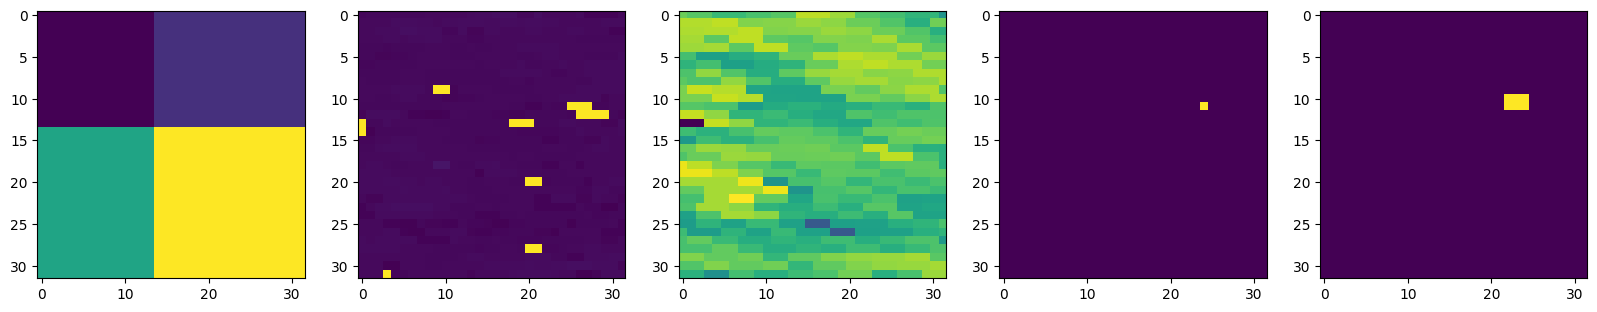

In [587]:
gen = generator_train[4]
idx = 3
imgx1 = gen[0][idx][:, :, 4]
imgx2 = gen[0][idx][:, :, 5]
imgx3 = gen[0][idx][:, :, 6]
imgx4 = gen[0][idx][:, :, -1]
imgy = gen[1][idx]

fig, ax=plt.subplots(1, 5, figsize=(20,5))
ax[0].imshow(imgx1)
ax[1].imshow(imgx2)
ax[2].imshow(imgx3)
ax[3].imshow(imgx4)
ax[4].imshow(imgy)

In [458]:
imgx2.shape

(32, 32)

In [108]:
def get_model(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size)

    # Entry block
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = tf.keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = tf.keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = tf.keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = tf.keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = tf.keras.layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [678]:
# unet = get_model((32, 32, 8), 1)

unet = sm.Unet('resnet18', input_shape=(None, None, 8), encoder_weights=None, classes=1, activation='sigmoid')

In [608]:
unet = tf.keras.Sequential()
unet.add(tf.keras.Input(shape=((32, 32, 8))))
unet.add(tf.keras.layers.Conv2D(3, (1,1), activation="sigmoid", padding="same"))
unet.add(sm.Unet('resnet34', input_shape=(None, None, 3), encoder_weights="imagenet", classes=1, activation='sigmoid'))

In [679]:
import keras.backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [680]:
def diceCoef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def diceCoefLoss(y_true, y_pred):
    return (1-diceCoef(y_true, y_pred))

def jaccardDistance(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac =  (intersection + smooth) / (sum_ - intersection + smooth)
    return (1-jac) * smooth * K.log(K.sum(y_true)+1)

In [681]:
def set_regularization(model, 
                       kernel_regularizer=None, 
                       bias_regularizer=None, 
                       activity_regularizer=None):
    
    for layer in model.layers:
        
        # set kernel_regularizer
        if kernel_regularizer is not None and hasattr(layer, 'kernel_regularizer'):
            layer.kernel_regularizer = kernel_regularizer

        # set bias_regularizer
        if bias_regularizer is not None and hasattr(layer, 'bias_regularizer'):
            layer.bias_regularizer = bias_regularizer

        # set activity_regularizer
        if activity_regularizer is not None and hasattr(layer, 'activity_regularizer'):
            layer.activity_regularizer = activity_regularizer

# exmaple
set_regularization(unet, kernel_regularizer=tf.keras.regularizers.l2(0.0001))

In [682]:
# unet = sm.Unet('resnet34', input_shape=(None, None, 8), encoder_weights=None, classes=1, activation='sigmoid')

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

unet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3), loss=total_loss, metrics=[sm.metrics.FScore(threshold=0.5), sm.metrics.iou_score]
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="unet.keras", 
    monitor='val_iou_score',
    mode='max',
    save_best_only=True)


callbacks = [
    model_checkpoint_callback
]

In [683]:
# MAIX
epochs = 50
unet.fit(
    generator_train,
    epochs=epochs,
    validation_data=generator_valid,
    callbacks=callbacks,
)
unet.load_weights("unet.keras")

Epoch 1/50
51/51 [==============================] - 12s 92ms/step - loss: 0.8881 - f1-score: 0.2409 - iou_score: 0.0929 - val_loss: 1.0236 - val_f1-score: 0.2205 - val_iou_score: 0.0988
Epoch 2/50
51/51 [==============================] - 3s 51ms/step - loss: 0.8326 - f1-score: 0.3082 - iou_score: 0.1232 - val_loss: 0.9899 - val_f1-score: 0.1104 - val_iou_score: 0.0803
Epoch 3/50
51/51 [==============================] - 2s 47ms/step - loss: 0.7926 - f1-score: 0.3396 - iou_score: 0.1564 - val_loss: 1.0139 - val_f1-score: 0.0502 - val_iou_score: 0.0391
Epoch 4/50
51/51 [==============================] - 2s 46ms/step - loss: 0.7771 - f1-score: 0.3477 - iou_score: 0.1743 - val_loss: 1.0838 - val_f1-score: 0.0158 - val_iou_score: 0.0126
Epoch 5/50
51/51 [==============================] - 3s 49ms/step - loss: 0.7745 - f1-score: 0.3453 - iou_score: 0.1787 - val_loss: 1.0607 - val_f1-score: 0.0494 - val_iou_score: 0.0308
Epoch 6/50
51/51 [==============================] - 2s 48ms/step - loss: 0

In [174]:
unet.load_weights("unet.keras")

In [684]:
gen = generator_test[0]
pred = unet(gen[0])

In [546]:
np.sum((pred[:, :, :, 0] - gen[1])**2) / (480*32*32)

0.009576435883839924

In [685]:
sm.metrics.iou_score((pred>0.5).numpy().astype(int), gen[1][..., None][0]).numpy()

0.10609779289013066

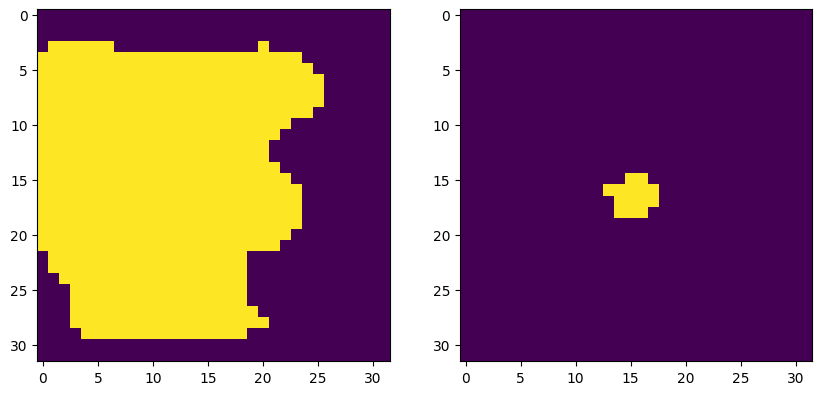

In [688]:
idx = 0
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax = ax.flatten()
ax[0].imshow(pred[1]>0.5)
ax[1].imshow(gen[1][1])
# ax[2].imshow(gen[0][44][:, :, 7])

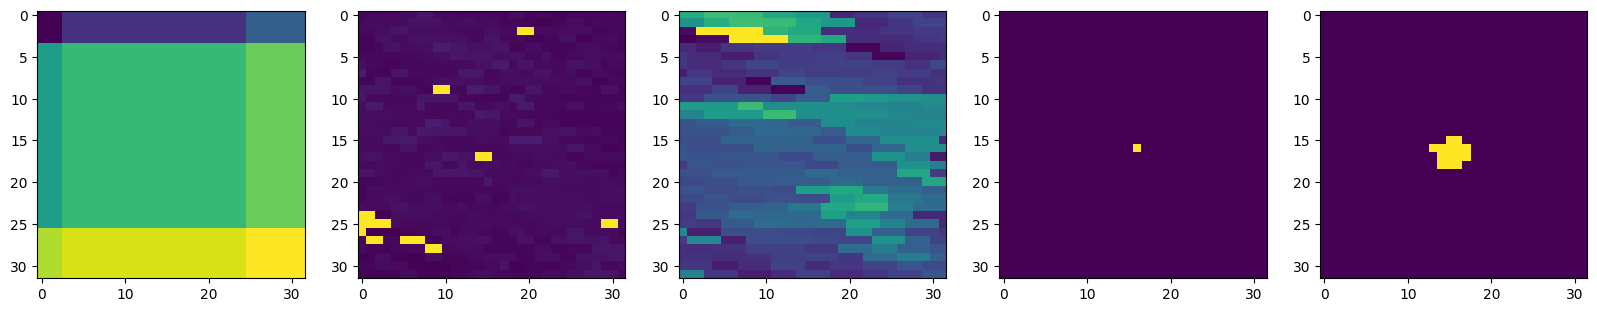

In [689]:
idx = 1
imgx1 = gen[0][idx][:, :, 4]
imgx2 = gen[0][idx][:, :, 5]
imgx3 = gen[0][idx][:, :, 6]
imgx4 = gen[0][idx][:, :, -1]
imgy = gen[1][idx]

fig, ax=plt.subplots(1, 5, figsize=(20,5))
ax[0].imshow(imgx1)
ax[1].imshow(imgx2)
ax[2].imshow(imgx3)
ax[3].imshow(imgx4)
ax[4].imshow(imgy)

InvalidArgumentError: slice index 46 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

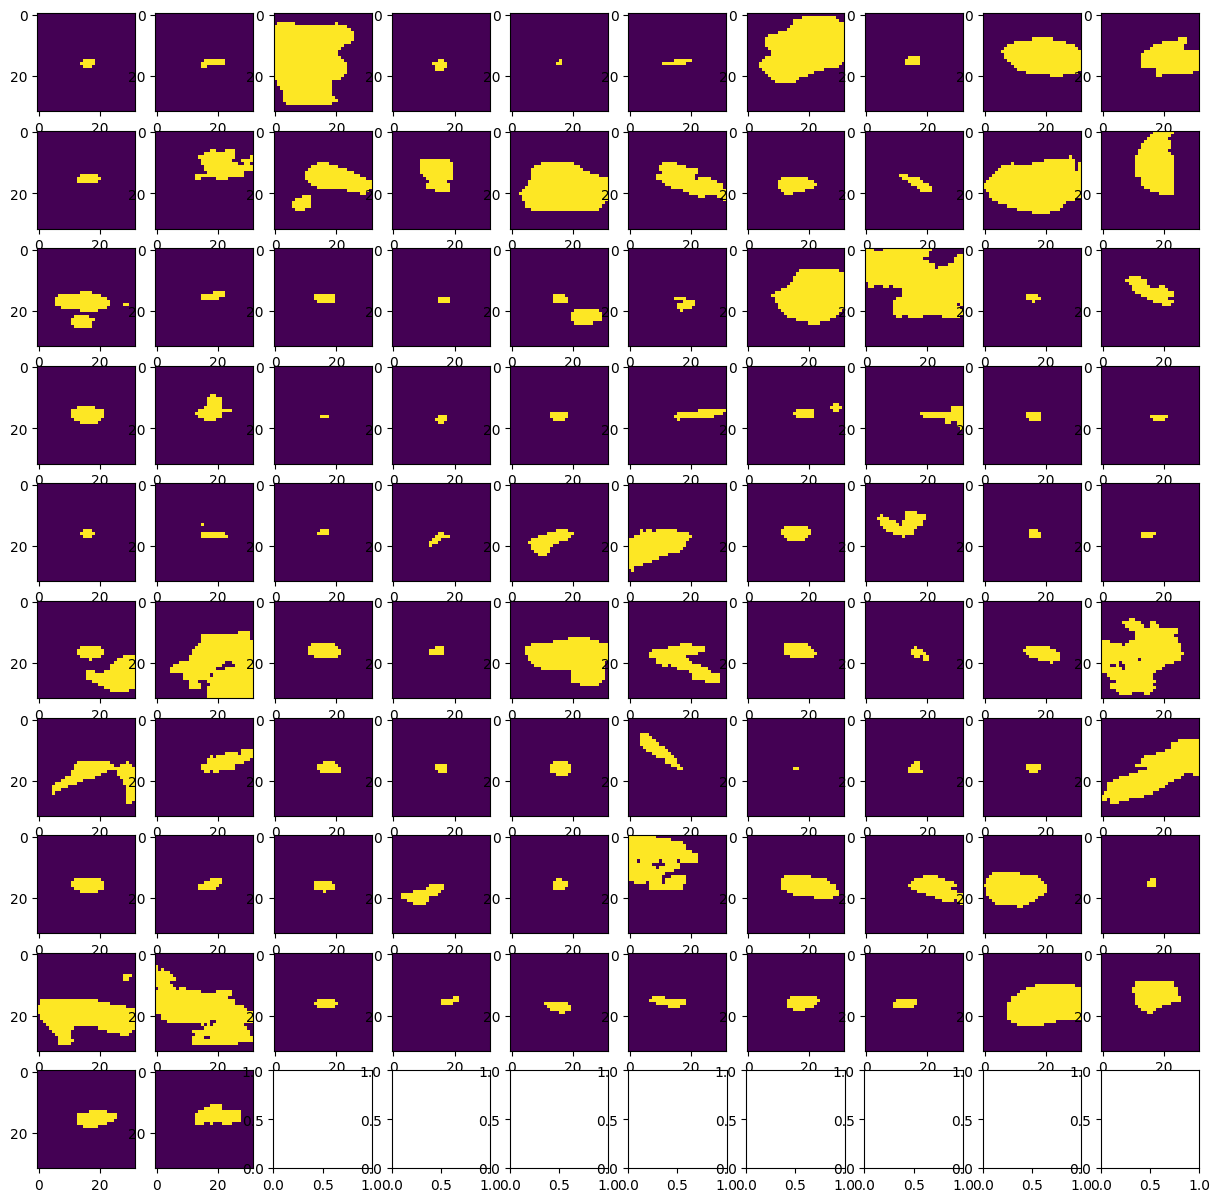

In [687]:
idx = 0
fig, ax = plt.subplots(10, 10, figsize=(15,15))
ax = ax.flatten()
for i in range(0, 10*10, 2):

    ax[i].imshow(pred[idx]>0.5)
    ax[i+1].imshow(gen[1][idx])
    idx += 1

In [ ]:
idx = 0
fig, ax = plt.subplots(10, 10, figsize=(15,15))
ax = ax.flatten()
for i in range(0, 10*10, 2):

    ax[i].imshow(pred[idx]>0.5)
    ax[i+1].imshow(gen[1][idx])
    idx += 1

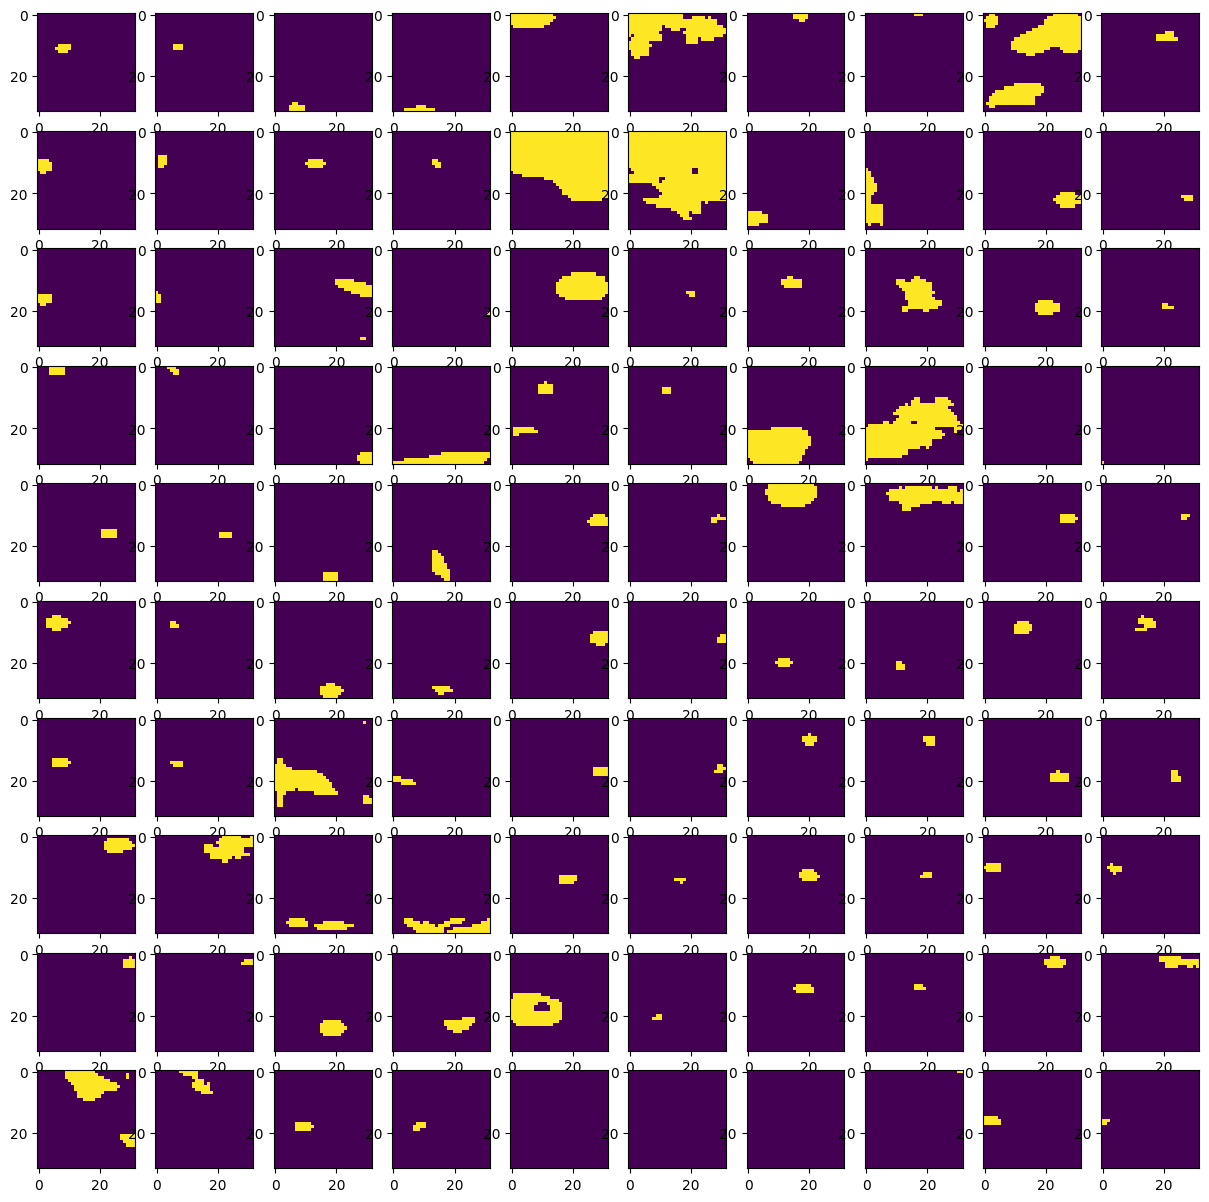

In [454]:
idx = 0
fig, ax = plt.subplots(10, 10, figsize=(15,15))
ax = ax.flatten()
for i in range(0, 10*10, 2):

    ax[i].imshow(pred[idx]>0.5)
    ax[i+1].imshow(gen[1][idx])
    idx += 1

In [200]:
gen_small = generator_test_small[0]
pred_small = unet(gen_small[0])

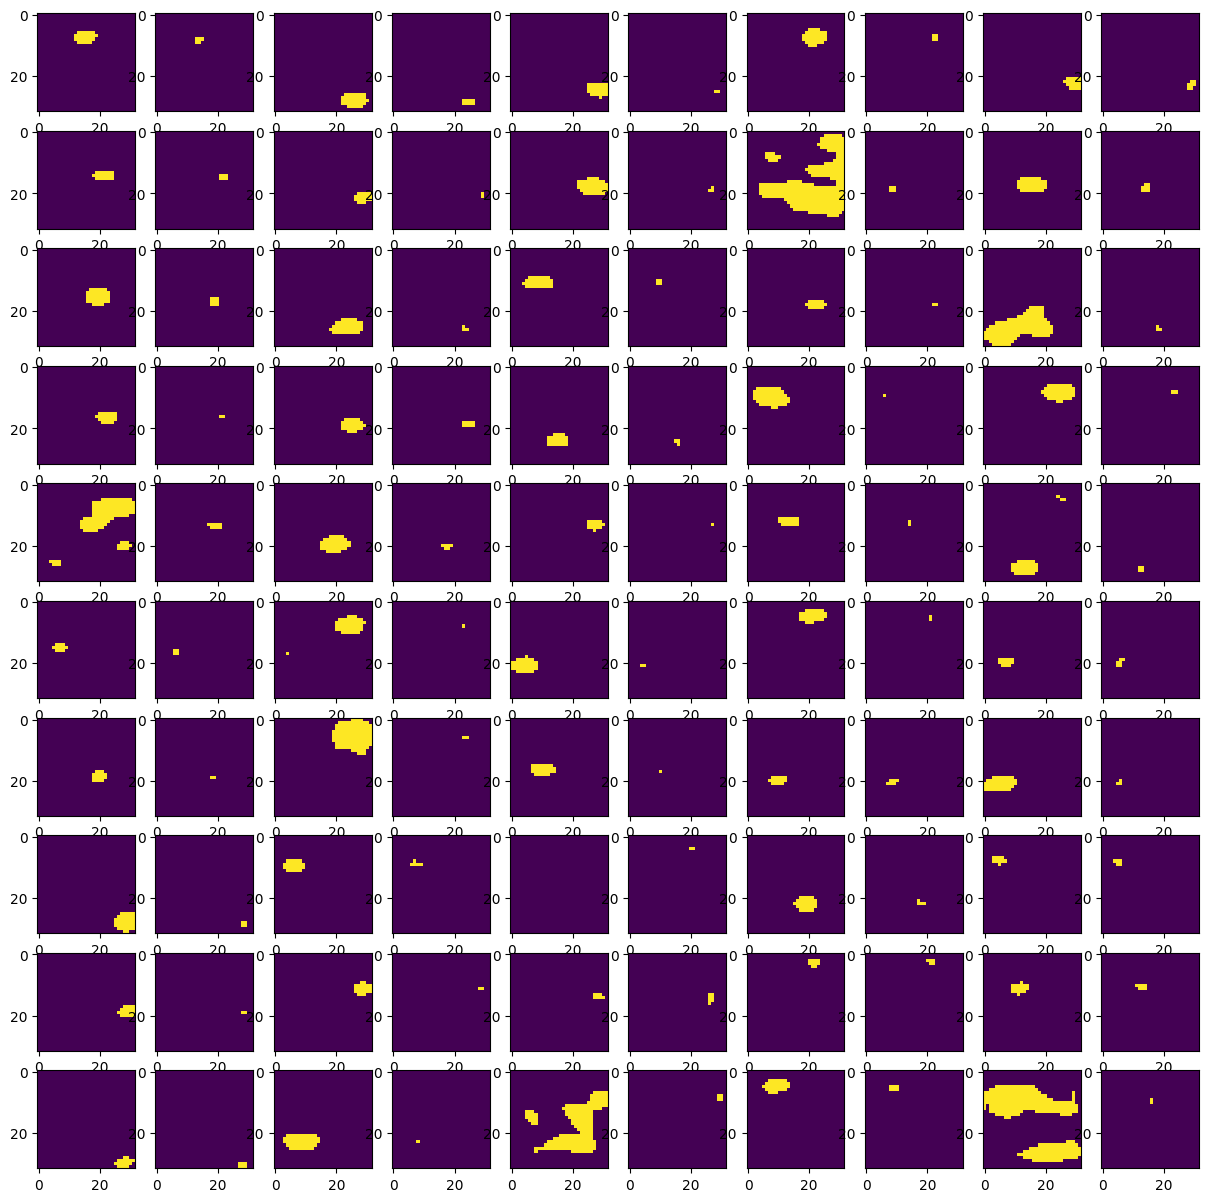

In [201]:
idx = 0
fig, ax = plt.subplots(10, 10, figsize=(15,15))
ax = ax.flatten()
for i in range(0, 10*10, 2):

    ax[i].imshow(pred_small[idx]>0.5)
    ax[i+1].imshow(gen_small[1][idx])
    idx += 1

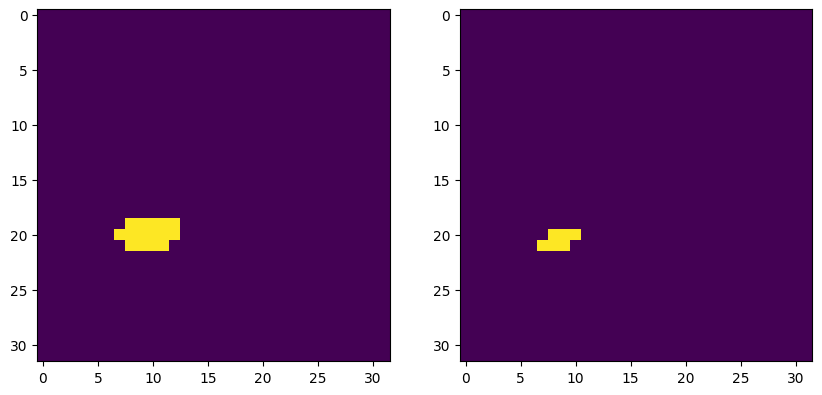

In [204]:
idx = 0
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax = ax.flatten()
ax[0].imshow(pred_small[33]>0.5)
ax[1].imshow(gen_small[1][33])
# ax[2].imshow(gen[0][44][:, :, 7])

In [ ]:
plt.imshow(pred[39])
plt.colorbar()

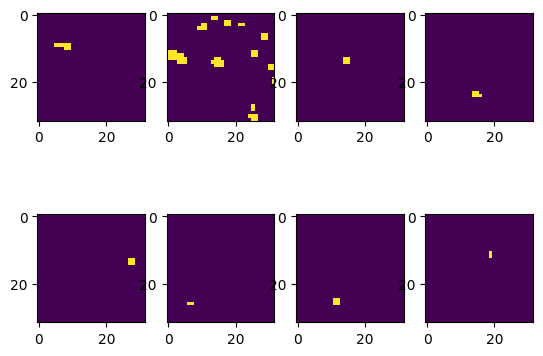

In [248]:
fig, ax = plt.subplots(2, 4)
ax = ax.flatten()
idx = 1
ax[0].imshow(gen[1][idx+1])
ax[1].imshow(gen[1][idx+2])
ax[2].imshow(gen[1][idx+3])
ax[3].imshow(gen[1][idx+4])

ax[4].imshow(gen[1][idx+5])
ax[5].imshow(gen[1][idx+6])
ax[6].imshow(gen[1][idx+7])
ax[7].imshow(gen[1][idx+8])

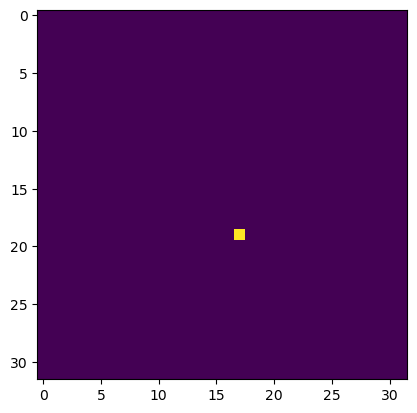

In [383]:
plt.imshow(gen[0][39][:, :, -1])